In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
from scipy.optimize import curve_fit

# Load Meta-RL results

In [2]:

engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "darkroom_simple"

env_name = "darkroom_fixedxy_dim5_corr0.0_state_dim2_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd256_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd256_layer3_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_fixedxy_dim5_corr0.0_state_dim2_envs1500000_H150_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs1500000_H150_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs1500000_H150_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch1024"

env_name = "darkroom_dim8_corr0.25_state_dim10_envs1500000_H250_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch512"

model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
path_to_pkl = os.path.join(model_path, 'eval_results_offline.pkl')


In [3]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
metarl_df = pd.DataFrame(data)
metarl_df.head()

,model,return,environment,experienced_reward,context_length,path_length_scaled
0,Learner (temp=2),0.000000,0,0,0,1.000000
1,Learner (temp=1),0.000000,0,0,0,1.000000
2,Learner (greedy),0.000000,0,0,0,1.000000
3,Learner (temp=2),0.085714,0,0,10,0.914286
4,Learner (temp=1),0.042857,0,0,10,0.957143


# Plot all results

In [4]:
# Concatenate the dataframes
df = metarl_df


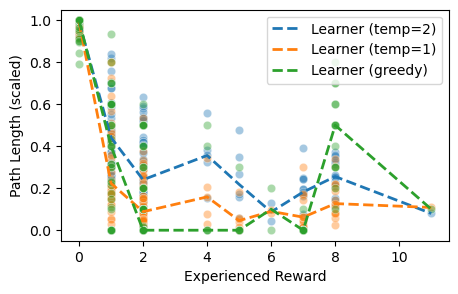

In [5]:
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

rlim = 15
_df = df[df['experienced_reward'] < rlim]

fig, ax = plt.subplots(figsize=(5,3))
for model in df['model'].unique():
    __df = _df[_df['model'] == model]
    alpha = 0.1 if model == 'DQN' else 0.4
    sns.scatterplot(
        data=__df, x='experienced_reward', y='path_length_scaled',
        ax=ax, alpha=alpha)
    
    # Group by experienced_reward and get mean path_length_scaled
    x = __df['experienced_reward']
    y = __df['path_length_scaled']
    grouped = __df.groupby('experienced_reward')['path_length_scaled'].median().reset_index()
    mean_x = grouped['experienced_reward']
    mean_y = grouped['path_length_scaled']
    
    popt, _ = curve_fit(exp_func, x, y, p0=[1, 1e-3, 0])
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = exp_func(x_fit, *popt)
    ax.plot(mean_x, mean_y, '--', label=model, linewidth=2)
ax.legend()
plt.xlabel('Experienced Reward')
plt.ylabel('Path Length (scaled)')
plt.show()


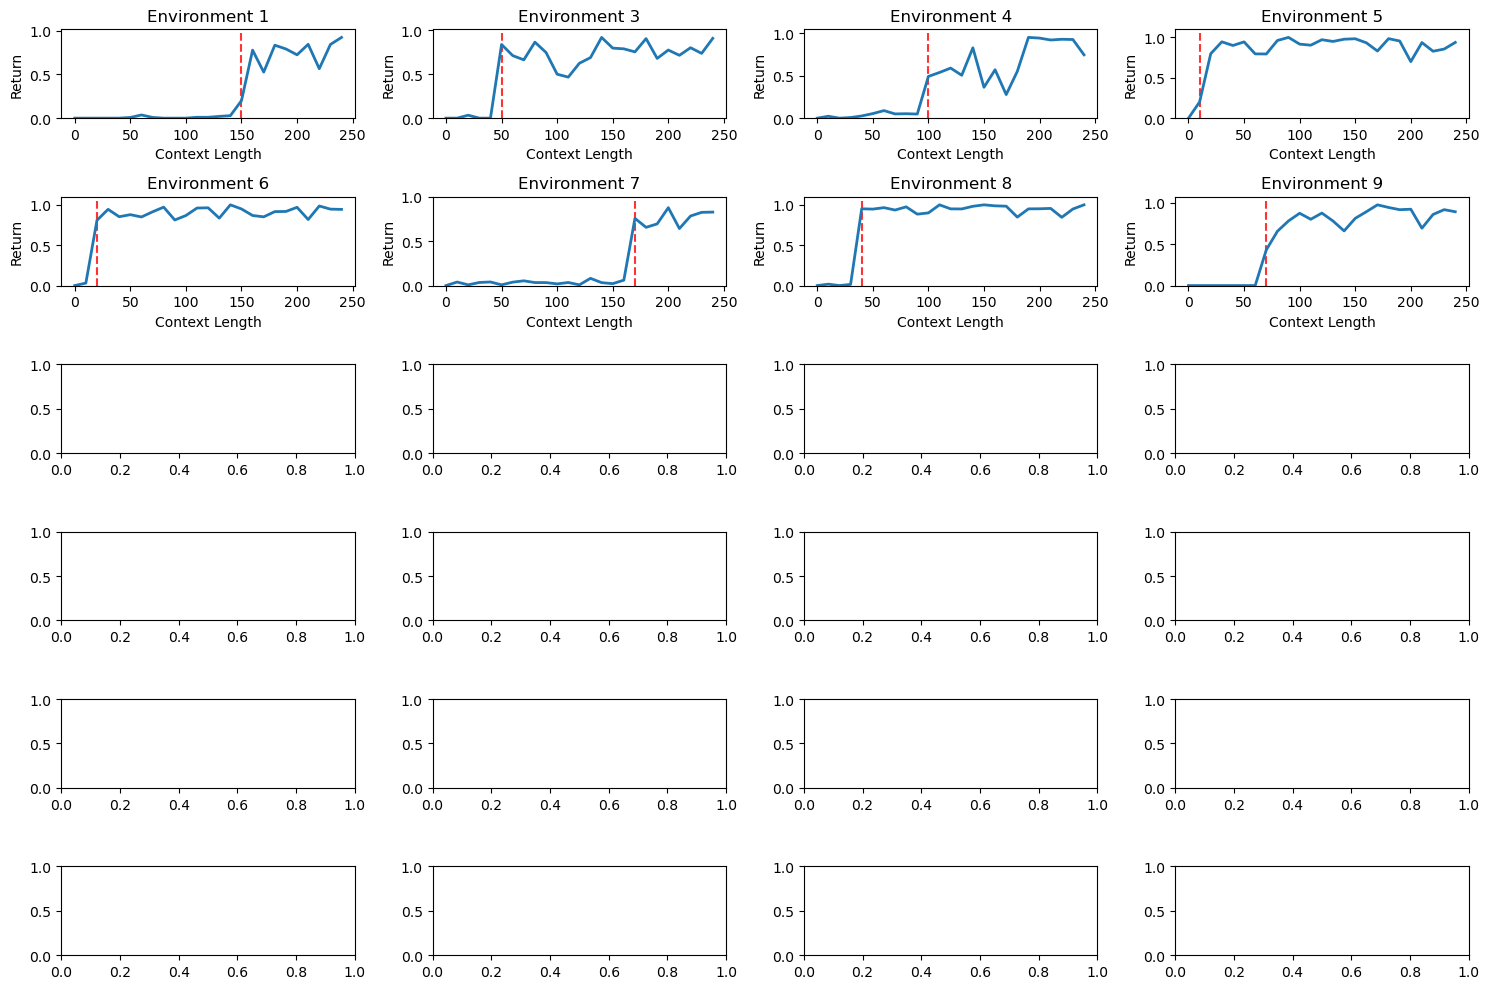

In [6]:
rlim = 30
_df = df[df['model'] == 'Learner (temp=1)']
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 1000:
        axes[n_envs_plotted].axvline(x=first_reward, color='r', linestyle='--', alpha=0.8)
    else:
        continue
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='return',
        ax=axes[n_envs_plotted],
        linewidth=2
    )
    axes[n_envs_plotted].set_title(f'Environment {env}')
    axes[n_envs_plotted].set_xlabel('Context Length')
    axes[n_envs_plotted].set_ylabel('Return')
    axes[n_envs_plotted].set_ylim(0, max(1, env_df['return'].max()*1.1))

    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.show()
